### Imports

In [1]:
! pip install networkx
! pip install plotly
! pip install colorlover


In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import colorlover as cl
from IPython.display import HTML
import random
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.graph_objects as go
init_notebook_mode(connected=True)
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Load Data

In [0]:
df = pd.read_csv("tweets2009-06-0115.csv.zip", sep='\t', compression='zip')

### Q1. Choose a hash-tag

In [4]:
tehranTag = df[df["tweet"].str.lower().str.contains("#tehran", na=False)].copy()
tehranTag.head()

date  ...                                              tweet
181948  2009-06-11 21:54:33  ...  RT @BreakingTweets: BREAKING: SMS services in ...
182126  2009-06-11 21:54:43  ...  RT @BreakingTweets: BREAKING: SMS services in ...
198805  2009-06-11 22:11:47  ...  #SMS system down in #Iran, hours before electi...
205631  2009-06-11 22:22:23  ...  @BreakingTweets #SMS system down in #Iran, hou...
220709  2009-06-11 22:49:45  ...  Campaign.com: New role for Web in Iranian poli...

[5 rows x 3 columns]

### Q2. Build a Mention Graph

In [0]:
def addMentionedColumn(df):
    
    def mentionsList(txt):
        allWords = [word.strip(""" ,.:'\";""").lower() for word in txt.split()]
        allNames = [word.strip("@") for word in allWords if word.startswith("@")]
        uniqueNames = list(set(allNames))
        return allNames
    
    df["mentioned"] = df["tweet"].apply(mentionsList)

In [0]:
def mentionGraph(df):
    g = nx.Graph()
    
    for (index, date, user, tweet, mentionedUsers) in df.itertuples():
        for mentionedUser in mentionedUsers:
            if (user in g) and (mentionedUser in g[user]):
                g[user][mentionedUser]["numberMentions"] += 1
            else:
                g.add_edge(user, mentionedUser, numberMentions=1)
    
    return g

In [0]:
# Prepare dataset
addMentionedColumn(tehranTag)

# Create mention graph
tagGraph = mentionGraph(tehranTag)

#### (a) How many nodes and how many edges in your mention graph?

In [8]:
print("# nodes:", len(tagGraph.nodes()))
print("# edges:", len(tagGraph.edges()))

# nodes: 637
# edges: 788


#### (b) Build a histogram of the graph nodes' degree

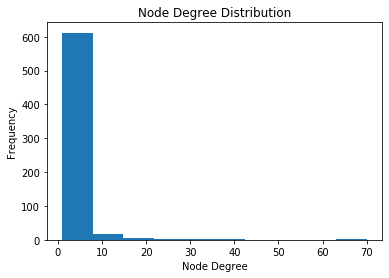

In [9]:
plt.hist(list(dict(nx.degree(tagGraph)).values()))
plt.title("Node Degree Distribution")
plt.xlabel("Node Degree")
plt.ylabel("Frequency")
fig = plt.gcf()

Only few accounts are mentioned by many people.

#### (c) Provide a list of top 5 edges with highest weights

In [0]:
def countEdgeWeight(graph):
    edgeList = []
    for node1, node2 in graph.edges():
        edgeList.append([node1, node2, tagGraph[node1][node2]['numberMentions']])
    
    weightDf = pd.DataFrame(edgeList)
    weightDf.columns = ["Node 1", "Node 2", "Edge Weight"]
    return weightDf

In [11]:
#  Find top 5 edges by weight
edgeWeightList = countEdgeWeight(tagGraph)
edgeWeightList.sort_values('Edge Weight',ascending=0).head(5)

Node 1       Node 2  Edge Weight
91         anabell39  mousavi1388            4
385             gita  grahattalab            4
197  steve_schippert  resemblance            3
295           gr8rdh    mommadona            3
75          jslefanu   potent_one            3

In [12]:
tagGraph.edges.data()

EdgeDataView([('danieldoyle', 'breakingtweets', {'numberMentions': 2}), ('breakingtweets', 'thedepotcafe', {'numberMentions': 1}), ('breakingtweets', 'mythary', {'numberMentions': 1}), ('breakingtweets', 'aceman808', {'numberMentions': 1}), ('breakingtweets', 'poisonthemonkey', {'numberMentions': 1}), ('breakingtweets', 'iamsharpe', {'numberMentions': 1}), ('breakingtweets', 'trekkerguy', {'numberMentions': 1}), ('breakingtweets', 'jessiejessup', {'numberMentions': 1}), ('breakingtweets', 'clneeley', {'numberMentions': 1}), ('breakingtweets', 'ckanal', {'numberMentions': 1}), ('breakingtweets', 'silsb33', {'numberMentions': 1}), ('breakingtweets', 'bettinatizzy', {'numberMentions': 1}), ('breakingtweets', 'sigrun_', {'numberMentions': 1}), ('breakingtweets', 'jjliber', {'numberMentions': 1}), ('breakingtweets', 'nickolaswriter', {'numberMentions': 1}), ('breakingtweets', 'mdrfl', {'numberMentions': 1}), ('breakingtweets', 'kelseyproud', {'numberMentions': 1}), ('breakingtweets', 'dpbyr

#### (d) Provide a visualization of the mention graph in which the edge color reflects its weight

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [0]:
def addRandomPositions(graph):
    posDict = dict((node,(random.gauss(0,10),random.gauss(0,10))) for node in graph.nodes())
    nx.set_node_attributes(graph, name="pos", values=posDict)

In [0]:
def getLineColor(edgeWidth):
        cells = 300
        # map color scale to edge weight scale
        blues = cl.scales['9']['seq']['PuRd']
        weightColor = cl.interp(blues, cells)
        lineColor = int((cells-1)*((edgeWidth-minEdgeWeight)/(maxEdgeWeight-minEdgeWeight)))
        
        return weightColor[lineColor]

In [0]:
def plotNetworkWeightColor(graph,minEdgeWeight, maxEdgeWeight):
    closenessCentr = nx.closeness_centrality(graph)
    maxCentr = max(closenessCentr.values())
    minCentr = min(closenessCentr.values())
    
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(color=getLineColor(edgeWidth)))
        scatters.append(s)



    for node in graph.nodes():
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                hoverinfo='none',
                mode='markers', 
                marker=dict(
                    color="#888", 
                    size=10,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [0]:
addRandomPositions(tagGraph)

In [18]:
# find max and min edge weights in the graph
maxEdgeWeight = edgeWeightList.sort_values('Edge Weight',ascending=0).head(5).as_matrix()[0][2]
minEdgeWeight = edgeWeightList.sort_values('Edge Weight',ascending=1).head(5).as_matrix()[0][2]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [19]:
# Plot network where line color indicates edge weight
configure_plotly_browser_state()
plotNetworkWeightColor(tagGraph, minEdgeWeight, maxEdgeWeight)

### Q3. Content Analysis

In [0]:
def getUserTopKWords(df, userList, k=3):
    userWords = {}
    for user in userList:
        topkWords = countWords(df.loc[df['user']==user]['tweet'].as_matrix()).most_common(k)
        tweetCount = len(df.loc[df['user']==user]['tweet'])
        
        words = {}
        for word, count in topkWords:
            words[word] = count
            
        userWords[user] = {'tweetCount':tweetCount, 'words':words}
        
    return userWords

In [0]:
stopwordList = set(stopwords.words('english'))
    
# Add Possible Stop Words for twitter
stopwordList.add('http')
stopwordList.add('com')
def cleanword(word):
    return bool(len(word)>2 and 
                not word.startswith("@") and    # Remove users
                not word.startswith("#") and    # Remove other hash-tags
                not word.startswith("http") and # Remove links
                word not in stopwordList)

# Count word frequency in a list of documents, excluding terms in a stopword list
def countWords(corpus):
    counter = Counter()
    # Open the doc in the corpus and count the word frequency
    for doc in corpus:
        allWords = [word.strip(""" ,.:-'\";""").lower() for word in doc.split()]
        counter.update([word for word in allWords if cleanword(word)])
    return counter

#### (a)Analyze the most common words in all the tweets

In [22]:
# Top words that appear across all tweets for the selected hash-tag
pd.DataFrame(countWords(tehranTag['tweet'].as_matrix()).most_common(10), columns=["Word", "Count"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



Word  Count
0        iran    153
1      tehran    120
2      police    104
3     twitter     73
4  university     52
5        word     51
6    attacked     49
7   situation     48
8      photos     46
9       girls     46

Main themes of the tweets include talking about the situation of iran, and worrying about the politics of iran.

#### (b)Plot network with top words (k=3), add hover information for the nodes

In [0]:
def plotNetworkWeightColor_Q3(graph,minEdgeWeight, maxEdgeWeight,userTopK,centr=None):
    # Format node text labels to dispaly username and most common words
    def formatLabel(username):
        numTweet = userTopK[username]['tweetCount']
        userTopWords = userTopK[username]['words']
        topWords = ''
        for word in sorted(userTopWords, key=userTopWords.__getitem__, reverse=True):
            topWords += '{0} ({1}) '.format(word, userTopWords[word])
        if centr==None:
          return "User: {0}<br>Top Words: {1}<br>Number of Tweets: {2}".format(username, topWords, numTweet)
        else:
          nodeCentr = centr[node]
          return "User: {0}<br>Top Words: {1}<br>Number of Tweets: {2}<br>Closeness: {3:.3f}".format(username, topWords, numTweet,nodeCentr)
    def getMarker(node):
        if centr == None:
            return dict(color='#888', size = nx.degree(graph,node)*2, line=dict(width=2))
        else:
            cells = 300
            # map purd color scale
            purd = cl.scales['9']['seq']['PuRd']
            purd300 = cl.interp(purd, cells)
            maxCentr = max(centr.values())
            minCentr = min(centr.values())
            nodeCentr = centr[node]
            nodeColor = int((cells-1)*(nodeCentr-minCentr)/(maxCentr-minCentr))
    
            return dict(color=purd300[nodeColor], 
                        size =nx.degree(graph,node)*2,
                        line=dict(width=2))
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color='#888'))
        scatters.append(s)



    for node in graph.nodes():
        xPos, yPos = graph.nodes[node]['pos']
        # Format node label
        labelText = 'User: {0}'.format(node)
        if bool(userTopK) and len(node)>0:
            labelText = formatLabel(node)
        
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text=labelText,
                hoverinfo='text',
                mode='markers', 
                marker=getMarker(node))
        scatters.append(s)
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [28]:
# Plot network with top words (k=3), where size is number of tweets
configure_plotly_browser_state()
plotNetworkWeightColor_Q3(tagGraph,minEdgeWeight, maxEdgeWeight, getUserTopKWords(tehranTag,tagGraph.nodes()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



### Q4. Centrality Analysis

In [29]:
nx.closeness_centrality(tagGraph)

{'': 0.18160714767727482,
 '1mohandes': 0.0015723270440251573,
 '21echoes': 0.12021154945683246,
 '31spoonerstreet': 0.13380068113456134,
 '7keystodeductit': 0.0015723270440251573,
 '_alexcar': 0.13095385813169833,
 '_freya': 0.01534081251062383,
 'abc': 0.14417194347122667,
 'abdu': 0.0015723270440251573,
 'aceman808': 0.1265006439725113,
 'acfoltzer': 0.17779187146556735,
 'actionchick': 0.10348997959964544,
 'adreier': 0.13380068113456134,
 'advorec': 0.12721372539287493,
 'aechenberg': 0.1106622174797124,
 'aefpix': 0.0015723270440251573,
 'af3': 0.1616598487442408,
 'akonsen': 0.0015723270440251573,
 'alazenby': 0.11991346910040392,
 'alexlobov': 0.0966911520338304,
 'alexruff': 0.003537735849056604,
 'aliasa': 0.110626053356353,
 'allahpundit': 0.1317694524213469,
 'altartist)': 0.0015723270440251573,
 'amadril': 0.1814124990731191,
 'amadril)': 0.12803166538216348,
 'amandagbeals': 0.17797882401179824,
 'amerikeith': 0.17779187146556735,
 'ammr': 0.0015723270440251573,
 'amrosar

In [30]:
nx.betweenness_centrality(tagGraph)

{'': 0.03257739547526881,
 '1mohandes': 0.0,
 '21echoes': 0.0,
 '31spoonerstreet': 0.0,
 '7keystodeductit': 0.0,
 '_alexcar': 0.0,
 '_freya': 0.0,
 'abc': 0.0,
 'abdu': 0.0,
 'aceman808': 0.0,
 'acfoltzer': 0.0,
 'actionchick': 0.0,
 'adreier': 0.0,
 'advorec': 0.015872827217352545,
 'aechenberg': 0.0,
 'aefpix': 0.0,
 'af3': 0.004778234049850031,
 'akonsen': 0.0,
 'alazenby': 0.0,
 'alexlobov': 0.0,
 'alexruff': 0.0,
 'aliasa': 0.0,
 'allahpundit': 0.0,
 'altartist)': 0.0,
 'amadril': 0.009943473133725681,
 'amadril)': 3.961768929827168e-06,
 'amandagbeals': 0.0,
 'amerikeith': 0.0,
 'ammr': 0.0,
 'amrosario': 1.4856633486851878e-05,
 'amyjudd': 0.011532928917047157,
 'amyvdh': 0.0,
 'anabell39': 0.0908947085864466,
 'andrewfynn': 0.013444971929966609,
 'andylovell': 0.0,
 'andyv67': 0.0,
 'anemosnaftilos': 0.0,
 'angelfly72': 0.0,
 'angie1234p': 0.0,
 'annabushueva': 0.0,
 'anotherside': 0.002021940653644709,
 'anteekiran': 0.0,
 'april_itt': 0.015714521533864878,
 'arealist': 9.9044

In [31]:
# Plot network with top words (k=3), where size is number of tweets
configure_plotly_browser_state()
plotNetworkWeightColor_Q3(tagGraph,minEdgeWeight, maxEdgeWeight, getUserTopKWords(tehranTag,tagGraph.nodes()),nx.closeness_centrality(tagGraph))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [32]:
# Plot network with top words (k=3), where size is number of tweets
configure_plotly_browser_state()
plotNetworkWeightColor_Q3(tagGraph,minEdgeWeight, maxEdgeWeight, getUserTopKWords(tehranTag,tagGraph.nodes()),nx.betweenness_centrality(tagGraph))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



The key players of two methods are mostly the same. But from betweenness measure graph we can quickly find the biggest key player more obviously than the closeness measure. 

Of the tested methods, the betweeness measure was the most useful. The closeness measure was difficult to identify the major players with as many nodes had similar centality values. 

### Q5. Connectivity Patterns

#### (a)

In [33]:
print("Number of Maximal cliques: {0}".format(len([clique for clique in nx.find_cliques(tagGraph)])))

Number of Maximal cliques: 569


In [34]:
print("Graph's clique number: {0}".format(nx.graph_clique_number(tagGraph)))

Graph's clique number: 4


In [35]:
# 3.) Maximal cliques for each node
pd.DataFrame(list(nx.number_of_cliques(tagGraph).items()), 
             columns=['user', 'Maximal clique']).sort_values('Maximal clique',ascending=0)

user  Maximal clique
188            gita              54
81           wpxlse              38
62           iran09              24
1    breakingtweets              24
21    simonscotland              19
..              ...             ...
266      kimmyville               1
265        rvercesi               1
261         cnn)!?!               1
259     danweinbaum               1
636      dijitalboy               1

[637 rows x 2 columns]

In [36]:
# 4.) Size of the largest maximal clique containing each given node
pd.DataFrame(list(nx.node_clique_number(tagGraph).items()), 
             columns=['user', 'Maximal clique']).sort_values('Maximal clique',ascending=0)

user  Maximal clique
318    solidadrocks               4
403       profbrian               4
192        gmarkham               4
194   blindcyclists               4
196  getsmartmoodle               4
..              ...             ...
237        iranriot               2
236        dirk2112               2
234    surya_source               2
233      andrewfynn               2
636      dijitalboy               2

[637 rows x 2 columns]

#### (b)

In [0]:
tehranTag[tehranTag['user']=='solidadrocks']

date  ...                                        mentioned
2221349  2009-06-13 18:33:36  ...                                               []
2588927  2009-06-14 02:31:02  ...  [schillingfan, misha1234, pourmecoffee, dmf71)]
2603259  2009-06-14 02:47:35  ...                           [cbn2, cody_k, dmf71)]
2647629  2009-06-14 03:43:05  ...                                               []
2731118  2009-06-14 05:39:24  ...                                               []
2755115  2009-06-14 06:19:33  ...                      [newiran, gita, profbrian)]

[6 rows x 4 columns]

Based on the above values, this indicates that this network has a lot of cliques, but they are all fairly small. Combined with the centrality measures in Q4, and reviewing the tweet content, this suggests that majortiy of users are small groups of friends and concerned about the politics of iran.